In [2]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn
import pickle

# Define the autoencoder so pickle knows how to serialize it. 
# Later, we should actually save as a state_dict instead of a dumb pickle
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float32, l1_coef=0.0):
        super(AutoEncoder, self).__init__()
        
        # Only defining the decoder layer, encoder will share its weights
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=True)
        # Create a bias layer
        self.encoder_bias= nn.Parameter(torch.zeros(n_dict_components))

        
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        # Encoder is a Sequential with the ReLU activation
        # No need to define a Linear layer for the encoder as its weights are tied with the decoder
        self.encoder = nn.Sequential(nn.ReLU()).to(t_type)

        self.l1_coef = l1_coef
        self.activation_size = activation_size
        self.n_dict_components = n_dict_components

    def forward(self, x):
        c = self.encoder(x @ self.decoder.weight + self.encoder_bias)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)

        # Decoding step as before
        x_hat = self.decoder(c)
        return x_hat, c


    @property
    def device(self):
        return next(self.parameters()).device

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dictionaries

In [8]:
#Change these settings to load the correct autoencoder
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/layer-2-autoencoder.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
# filename = "outputs/20230804-205842-EleutherAI/pythia-70m-deduped-2/minirun4/autoencoders.pkl"

# filename = "outputs/20230805-205314-EleutherAI/pythia-70m-deduped-2/minirun14/autoencoders.pkl"
filename = "outputs/20230806-181211-gpt2-8/minirun9/autoencoders.pkl"
layer = 8
setting = "residual"
# model_name = "EleutherAI/pythia-70m-deduped"
model_name = "gpt2"

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = 3
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))
dict_index = 0
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries[dict_index+1]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders[l1_index][dict_index+1]

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
torch.Size([6144, 768])
torch.Size([12288, 768])
len of autoencoders:  6


In [185]:
#Change these settings to load the correct autoencoder
# filename = "/home/mchorse/logan_sparse_coding/sparse_coding/layer-2-autoencoder.pkl"
filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230720-192301-EleutherAI/pythia-70m-deduped-2/minirun5/autoencoders.pkl"
filename2 = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun9/autoencoders.pkl"
# filename = "outputs/20230721-161919-EleutherAI/pythia-70m-deduped-2/minirun3/autoencoders.pkl"
layer = 2
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
else:
    raise NotImplementedError


# Load the pickle file
with open(filename, 'rb') as file:
    autoencoders = pickle.load(file)

# Load the pickle file
with open(filename2, 'rb') as file:
    autoencoders2 = pickle.load(file)

# Index for l1 value, usually only 1 value is available
l1_index = 1
dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
dictionaries2 = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders2[l1_index]]
for d in dictionaries:
    print(d.shape)
print("len of autoencoders: ", len(autoencoders))
dict_index = 1
smaller_dict, larger_dict = dictionaries[dict_index], dictionaries2[dict_index]
smaller_auto_encoder, larger_auto_encoder = autoencoders[l1_index][dict_index], autoencoders2[l1_index][dict_index]

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
torch.Size([2048, 512])
torch.Size([4096, 512])
torch.Size([8192, 512])
len of autoencoders:  3


In [7]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
# DO THE MCS across all dictionaries
def mcs(dict1, dict2):
    dict1_features, _ = dict1.shape
    dict2_features, _ = dict2.shape
    dict2 = dict2.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((dict1_features, dict2_features))
    for idx, vector in enumerate(dict1):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), dict2, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]
    max_indices = np.argsort(max_cosine_similarities)[::-1].copy()
    return max_cosine_similarities, max_indices


l1_index = 3
# dictionaries = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders[l1_index]]
# dictionaries2 = [autoencoder.decoder.weight.data.T for autoencoder in autoencoders2[l1_index]]
dictionaries = [autoencoder[0].decoder.weight.data.T for autoencoder in autoencoders]
# combined_dicts = dictionaries + dictionaries2
combined_dicts = dictionaries
adjancy_matrix = np.zeros((len(combined_dicts), len(combined_dicts)))
for i in tqdm(range(len(combined_dicts))):
    for j in range(len(combined_dicts)):
        if j > i:
            break
        max_cosine_similarities, max_indices = mcs(combined_dicts[i], combined_dicts[j])
        adjancy_matrix[i, j] = max_cosine_similarities.mean()
        adjancy_matrix[j, i] = max_cosine_similarities.mean()

 50%|█████     | 3/6 [00:49<00:49, 16.62s/it]


KeyboardInterrupt: 

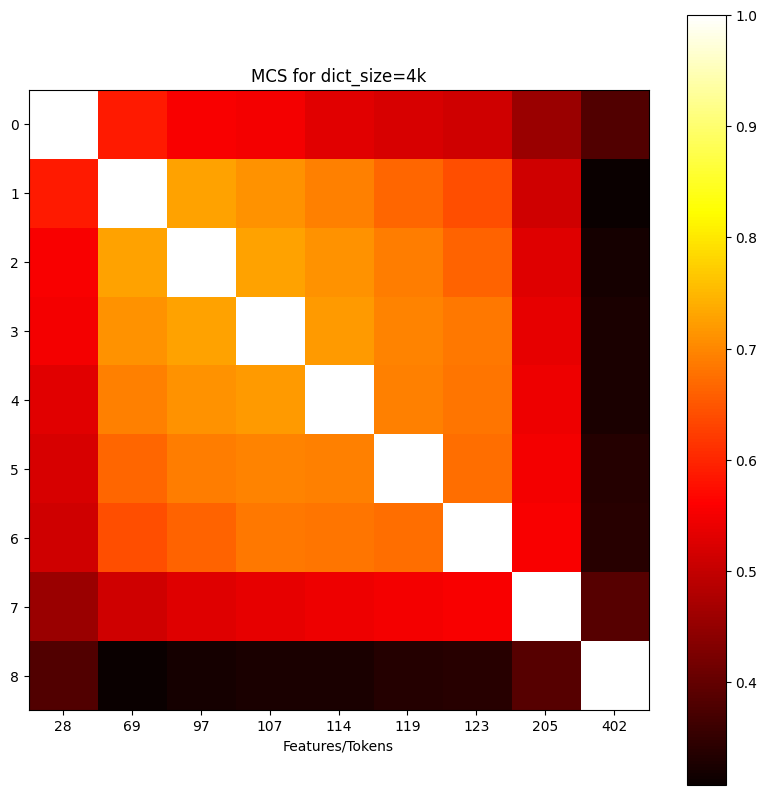

In [5]:
# Plot the adjancy matrix
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for dict_size=4k")
# sparsities = [28,69,94,95,113,115,126,205,393]
sparsities = [28, 69, 97, 107, 114, 119, 123, 205, 402]
# sparsities are x-axis
plt.xticks(range(len(sparsities)), sparsities)
plt.xlabel("Features/Tokens")
plt.colorbar()
plt.show()

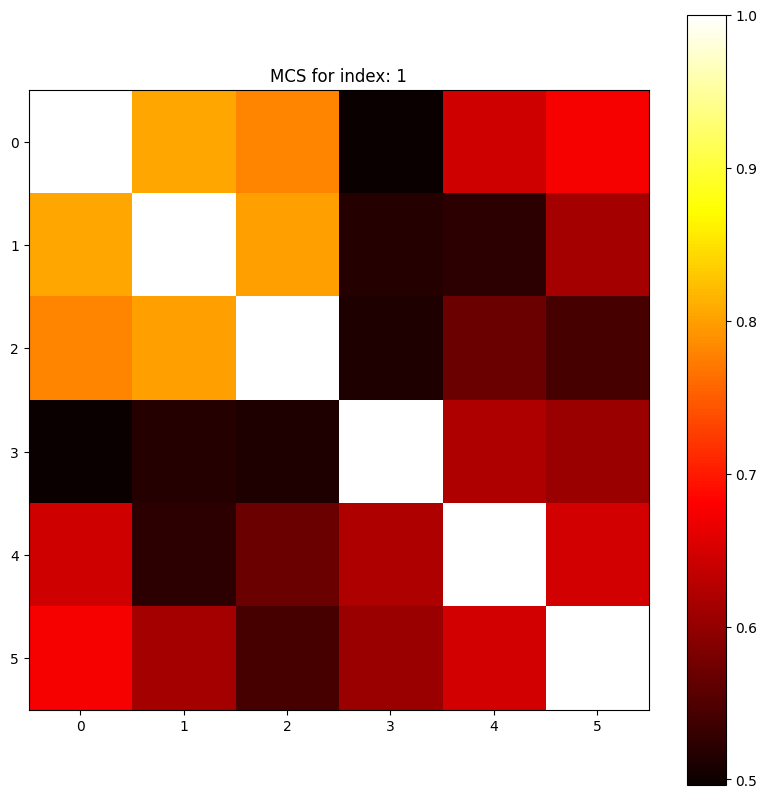

In [199]:
# Plot the adjancy matrix
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for index: " + str(l1_index))
plt.colorbar()
plt.show()

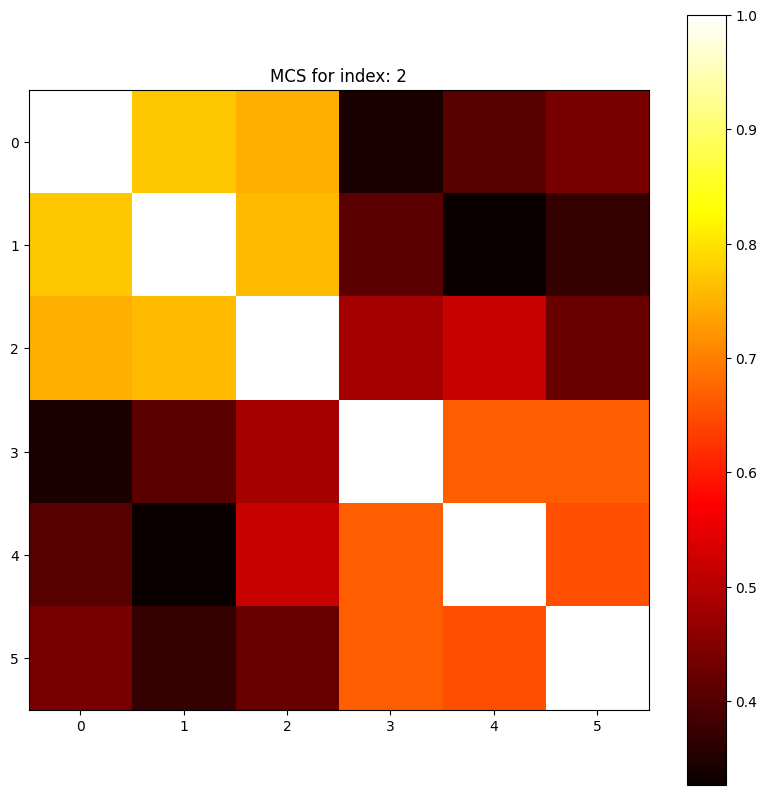

In [203]:
# Plot the adjancy matrix
plt.figure(figsize=(10, 10))
plt.imshow(adjancy_matrix, cmap='hot', interpolation='nearest')
plt.title("MCS for index: " + str(l1_index))
plt.colorbar()
plt.show()

In [192]:
max_cosine_similarities.mean()

0.4964340803012419

# MCS
Max cosine similarity between one dictionary & another one. If they learned the same feature, then they'll have high cosine similarity. 

If two dictionaries learned it, it's probably a real feature.

('# of features above 0.9:', 2768)


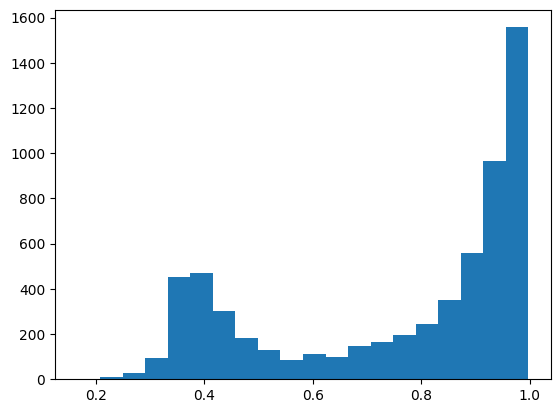

In [9]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
#Dictionary Comparison
smaller_dict_features, _ = smaller_dict.shape
larger_dict_features, _ = larger_dict.shape
larger_dict = larger_dict.to(device)
# Hungary algorithm
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
for idx, vector in enumerate(smaller_dict):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1].copy()
print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))
# Plot histogram of max_cosine_similarities
plt.hist(max_cosine_similarities, bins=20)
plt.show()

# Model activations & Dictionary Activations

In [10]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 40
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Map:   0%|          | 0/10000 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (3180 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 64
neuron_activations = torch.zeros((datapoints*token_amount, neurons))
dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
smaller_auto_encoder = smaller_auto_encoder.to(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        reconstruction, batched_dictionary_activations = smaller_auto_encoder(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

100%|██████████| 155/155 [00:17<00:00,  8.75it/s]


# Feature Activation Analysis

## Useful Functions

In [424]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            _, act = smaller_auto_encoder(neuron_act_batch)
            return act[0, :, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
def visualize_text(text, feature, model, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder, entire_feature_direction=False):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        _, act = autoencoder(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        # Subtract value with feature direction*act_of_feature
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), autoencoder.decoder.weight[:, feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value
    
    def ablated_this_feature_dir(value, hook):
        value -= feature
        return value
    if(entire_feature_direction):
        return model.run_with_hooks(tokens, 
            fwd_hooks=[(
                cache_name, 
                ablated_this_feature_dir
                )]
            )
    else:
        return model.run_with_hooks(tokens, 
            fwd_hooks=[(
                cache_name, 
                mlp_ablation_hook
                )]
            )

def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, features=None, setting="true_tokens", verbose=False, entire_feature_direction=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, smaller_auto_encoder, entire_feature_direction).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)
def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, smaller_dict, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = smaller_dict[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


In [347]:
#Ablate all directions one at a time, to see the effect of the logit on the output
# 1. get io & s token
# 2. get the logit of both tokens on a normal model run
# 3. get the logit of both tokens on a model run with the direction ablated
# 4. get the difference between the two logits, then print out topk features
ex_sent_A = [
    '<|endoftext|>Then, Richard and Jennifer were working at the plateau. Jennifer decided to give a feather to',
    '<|endoftext|>Then, Laura and Catherine were working at the cafe. Catherine decided to give a towel to',
    '<|endoftext|>Then, Parker and Jake were working at the glacier. Jake decided to give fins to',
    '<|endoftext|>Then, Tim and Wyatt were working at the garage. Wyatt decided to give a bible to',
    '<|endoftext|>Then, Sam and Peter were working at the chapel. Peter decided to give a remote to',
    '<|endoftext|>Then, Ross and Jason were working at the chapel. Jason decided to give a chalk to',
    '<|endoftext|>Then, Nathan and Eva were working at the cafe. Eva decided to give a vinyl to',
    '<|endoftext|>Then, Matt and Evan were working at the stadium. Evan decided to give a crate to',
]
ex_sent_B = [
    '<|endoftext|>Then, Taylor and Grant were working at the lounge. Taylor decided to give a shorts to',
    '<|endoftext|>Then, Jake and Kate were working at the synagogue. Jake decided to give a backpack to',
    '<|endoftext|>Then, Julia and Rose were working at the museum. Julia decided to give a wrench to',
    '<|endoftext|>Then, Jennifer and Brooklyn were working at the fortress. Jennifer decided to give a tape to',
    '<|endoftext|>Then, Mason and Jeff were working at the street. Mason decided to give a vinyl to',
    '<|endoftext|>Then, Richard and Jean were working at the cottage. Richard decided to give a lipstick to',
    '<|endoftext|>Then, Ross and Elijah were working at the home. Ross decided to give a flag to',
    '<|endoftext|>Then, Taylor and Matt were working at the palace. Taylor decided to give a bookmark to',
    '<|endoftext|>Then, Molly and Keith were working at the chapel. Molly decided to give a baseball to',
    '<|endoftext|>Then, Parker and Dean were working at the tunnel. Parker decided to give a tablet to',
    '<|endoftext|>Then, Kevin and Connor were working at the harbor. Kevin decided to give a bakery to',
    '<|endoftext|>Then, Matt and Riley were working at the garden. Matt decided to give a charcoal to',
    '<|endoftext|>Then, Keith and Joy were working at the plateau. Keith decided to give a ring to',
    '<|endoftext|>Then, Ruby and Ray were working at the brewery. Ruby decided to give a lipstick to',
]
ex_sent = ex_sent_A + ex_sent_B
all_A = []
all_B = []

for sentence in ex_sent_A:
    # Split the sentence by 'and' and 'were' to get the names
    names = sentence.split('and')[0].split()[-1]
    all_A.append(" " + names)
    
    names = sentence.split('and')[1].split('were')[0].strip()
    all_B.append(" " + names)

for sentence in ex_sent_B:
    # Split the sentence by 'and' and 'were' to get the names
    names = sentence.split('and')[0].split()[-1]
    all_B.append(" " + names)
    
    names = sentence.split('and')[1].split('were')[0].strip()
    all_A.append(" " + names)


print(all_A)
print(all_B)
sentence_token = model.to_tokens(ex_sent, prepend_bos=False)
all_A_tokens = [model.to_single_token(A) for A in all_A]
all_B_tokens = [model.to_single_token(B) for B in all_B]

#2
with torch.no_grad():
    logits = model(sentence_token).log_softmax(-1)
    A_logits = logits[torch.arange(len(all_A_tokens)), -1, all_A_tokens]
    B_logits = logits[torch.arange(len(all_B_tokens)), -1, all_B_tokens]

print('A_logit: ', A_logits)
print('B_logit: ', B_logits)
#import partial
from functools import partial
from tqdm import tqdm

#3
def mlp_ablation_hook(value, hook, feature_to_ablate):
    # Rearrange to fit autoencoder
    int_val = rearrange(value, 'b s h -> (b s) h')

    # Run through the autoencoder
    _, act = smaller_auto_encoder(int_val)

    # Subtract value with feature direction*act_of_feature
    feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), smaller_auto_encoder.decoder.weight[:, feature_to_ablate].squeeze())
    batch, seq_len, hidden_size = value.shape
    feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
    value -= feature_direction
    return value

num_features = smaller_dict.shape[0]
diff_A = np.zeros(num_features)
diff_B = np.zeros(num_features)
with torch.no_grad():
    for feature_to_ablate in tqdm(range(num_features)):
        ablated_logits = model.run_with_hooks(sentence_token, fwd_hooks=[(cache_name, partial(mlp_ablation_hook, feature_to_ablate=feature_to_ablate))])
        ablated_logits = ablated_logits.log_softmax(-1)

        A_ablated_logits = ablated_logits[torch.arange(len(all_A_tokens)), -1, all_A_tokens]
        B_ablated_logits = ablated_logits[torch.arange(len(all_B_tokens)), -1, all_B_tokens]

        diff_A[feature_to_ablate] = (A_logits - A_ablated_logits).mean().item()
        diff_B[feature_to_ablate] = (B_logits - B_ablated_logits).mean().item()

[' Richard', ' Laura', ' Parker', ' Tim', ' Sam', ' Ross', ' Nathan', ' Matt', ' Grant', ' Kate', ' Rose', ' Brooklyn', ' Jeff', ' Jean', ' Elijah', ' Matt', ' Keith', ' Dean', ' Connor', ' Riley', ' Joy', ' Ray']
[' Jennifer', ' Catherine', ' Jake', ' Wyatt', ' Peter', ' Jason', ' Eva', ' Evan', ' Taylor', ' Jake', ' Julia', ' Jennifer', ' Mason', ' Richard', ' Ross', ' Taylor', ' Molly', ' Parker', ' Kevin', ' Matt', ' Keith', ' Ruby']
A_logit:  tensor([ -0.6420,  -0.5697, -20.6690,  -1.4613,  -2.1344,  -2.5653,  -1.1778,
         -0.5647,  -0.5970,  -0.2841,  -1.7202,  -1.6440,  -0.5415,  -0.6980,
         -0.7469,  -0.9883,  -1.0942,  -0.6697,  -1.7540,  -2.4680,  -1.0339,
         -0.6514], device='cuda:5')
B_logit:  tensor([ -5.5163,  -3.3293, -20.0333,  -2.4085,  -3.7961,  -4.0405,  -5.3463,
         -4.7985,  -2.7412,  -6.1440,  -3.5804,  -3.9682,  -3.9589,  -5.2075,
         -8.4814,  -2.6365,  -2.8979,  -4.6182,  -4.5480,  -4.2179,  -2.8910,
         -2.6379], device='cuda:5'

  0%|          | 0/6144 [00:00<?, ?it/s]

100%|██████████| 6144/6144 [03:26<00:00, 29.72it/s]


In [110]:
A_logits, B_logits

(tensor([-1.5355, -0.3452, -1.0188], device='cuda:5'),
 tensor([-3.6249, -3.9121, -3.1256], device='cuda:5'))

In [122]:
# Topk of diff_A and diff_B
topk = 10
diff_A_tensor = torch.tensor(diff_A)
diff_B_tensor = torch.tensor(diff_B)
diff_A_topk = torch.topk(diff_A_tensor, topk)
diff_B_topk = torch.topk(diff_B_tensor, topk)
print("A we want lower:",diff_A_topk)
print("B we want Higher:", diff_B_topk)

A we want lower: torch.return_types.topk(
values=tensor([4.4833, 1.0377, 0.7852, 0.5161, 0.2330, 0.1923, 0.1923, 0.1911, 0.1763,
        0.1647], dtype=torch.float64),
indices=tensor([2270, 2865, 4809, 4236, 3527, 2188, 3499, 1263, 4211, 2675]))
B we want Higher: torch.return_types.topk(
values=tensor([4.2441, 0.6533, 0.4921, 0.4692, 0.2961, 0.1765, 0.1527, 0.1481, 0.1071,
        0.0864], dtype=torch.float64),
indices=tensor([2270, 1000, 4809, 2865, 4236,  612, 2769, 2188, 3806, 3499]))


In [121]:
# Also do topk of diff_A_tensor, etc , largest=False
#   612, 2769, 3806
#   4786, 1152, 3750, 1753, 3383, 6035, 5915, 1413
print("A we want lower:",torch.topk(diff_A_tensor, 10, largest=False))
print("B we want Higher:",torch.topk(diff_B_tensor, 10, largest=False))

A we want lower: torch.return_types.topk(
values=tensor([-0.1092, -0.0988, -0.0747, -0.0705, -0.0593, -0.0589, -0.0553, -0.0551,
        -0.0361, -0.0349], dtype=torch.float64),
indices=tensor([4786,  998, 1152, 3750, 1753, 3383, 6035, 4225, 5915, 1413]))
B we want Higher: torch.return_types.topk(
values=tensor([-1.6452, -0.6806, -0.4724, -0.2557, -0.2487, -0.2237, -0.1967, -0.1612,
        -0.1597, -0.1281], dtype=torch.float64),
indices=tensor([3527, 5112,  998, 2675, 4211, 2898, 4225, 4727, 3800, 2022]))


In [348]:
k = 50
diff_A_tensor = torch.tensor(diff_A)
diff_B_tensor = torch.tensor(diff_B)
low_A = torch.topk(diff_A_tensor, k, largest=False).indices
high_B = torch.topk(diff_B_tensor, k).indices
feature_list2 = []
for l_a in low_A:
    if(l_a in high_B):
        # print(l_a.item())
        feature_list2.append(l_a.item())
print(feature_list2)

[1152, 3383, 4727, 2277, 2022, 4840, 89, 3806, 1639, 2668]


In [349]:
diff_A_tensor = torch.tensor(diff_A)
diff_B_tensor = torch.tensor(diff_B)
k = 50
low_A = torch.topk(diff_A_tensor, k, largest=True).indices
high_B = torch.topk(diff_B_tensor, k, largest=False).indices
feature_list = []
for l_a in low_A:
    if(l_a in high_B):
        feature_list.append(l_a.item())
print(feature_list)

[612, 5112, 2142, 5051, 2188, 3921, 2898, 3936, 32, 4879, 5808, 3717, 5474, 2204, 5915]


In [352]:
original_feature = torch.tensor([ 2.4080e-02, 2.4359e-02, 2.5915e-03, 4.9120e-02, 1.2658e-01,
         3.2408e-02, -2.5182e-02, 4.3675e-02, -5.4410e-02, 1.6136e-02,
        -2.0048e-02, -2.2420e-02, 3.3210e-02, 3.4793e-02, -2.8834e-02,
         7.4147e-02, 3.7202e-02, 5.3582e-02, 1.1046e-03, 1.2104e-02,
         5.3141e-03, 1.5514e-02, -3.4517e-02, -1.2846e-02, -1.4674e-02,
         8.6960e-03, -1.5789e-02, 9.3915e-04, 5.9387e-04, -6.1752e-02,
         4.1706e-02, -6.9348e-02, 6.0245e-02, -1.5278e-02, 4.6114e-03,
        -6.0599e-02, 4.6384e-02, 8.7855e-03, 9.8222e-02, -1.4912e-02,
        -2.0680e-02, 8.0620e-04, 2.1009e-02, -1.8937e-02, 1.9966e-02,
         1.8603e-02, 9.0589e-02, -5.7756e-03, -4.1959e-02, 5.0267e-03,
         2.3697e-02, -5.8151e-02, -7.7805e-02, -4.9728e-02, -4.8614e-03,
        -3.9631e-02, -4.0052e-02, 3.9487e-02, 6.3542e-03, 2.7683e-02,
        -3.4077e-02, -2.9967e-02, 3.2453e-03, -8.4002e-02, -3.5077e-02,
        -9.1061e-03, -8.3716e-04, 7.6448e-03, -7.9082e-03, 3.9118e-02,
        -3.9306e-02, -2.0184e-02, -1.7360e-02, -9.5160e-03, 1.3632e-02,
        -1.1137e-01, -3.2181e-02, -5.6427e-02, -2.3615e-02, 9.5962e-03,
         5.5335e-02, -1.8662e-02, 3.4204e-02, -5.0086e-02, -7.4954e-02,
         8.4810e-03, 5.8262e-02, 1.7019e-02, 3.1432e-03, 1.1476e-02,
         6.3471e-03, -4.1524e-02, 1.8465e-02, 7.5723e-02, 1.5079e-02,
         1.9857e-02, 1.1886e-02, 9.8358e-03, -5.3220e-02, 5.9651e-02,
         2.2428e-02, 3.4533e-02, -1.7907e-02, 1.0397e-02, 4.1672e-02,
        -1.8936e-02, 2.1871e-02, 2.5337e-03, 2.3077e-03, 3.9737e-02,
        -3.9214e-02, 9.2625e-03, -3.8041e-02, -1.2577e-02, -3.1696e-03,
        -2.7372e-02, -5.1618e-02, 4.4042e-02, 2.4820e-02, 2.7953e-02,
         1.5850e-02, -1.6006e-03, 5.3238e-02, 9.8043e-03, 3.8326e-02,
        -4.1484e-02, 3.6432e-02, 2.2653e-02, 1.8522e-02, -3.7113e-02,
         1.7174e-02, -8.3303e-03, 2.8099e-03, 1.0931e-01, -4.4335e-02,
         1.1882e-02, -6.4499e-03, 3.7061e-02, -9.4151e-02, -5.1065e-02,
         2.7060e-02, -6.5621e-02, -3.0455e-02, -1.6427e-02, 3.9223e-02,
        -3.9643e-02, 6.4269e-04, -1.2907e-03, -5.0777e-03, -5.1587e-02,
        -3.4985e-02, 3.7856e-02, -9.9967e-02, -6.5395e-03, -4.6955e-02,
         2.4562e-02, 1.5419e-02, -2.1492e-02, -8.9394e-03, 4.2825e-02,
        -4.5467e-02, -1.2693e-02, -4.9931e-02, 1.9798e-03, -3.1977e-02,
         6.7696e-03, -3.7578e-02, -3.1094e-02, -3.4964e-02, 3.0003e-02,
         3.0392e-02, 2.8398e-02, 7.5477e-04, 2.7859e-02, 8.7245e-03,
         1.9231e-02, -3.1447e-02, -3.8160e-02, 3.6587e-02, -1.2608e-02,
         6.7020e-02, 9.5656e-02, 2.0806e-02, -1.0801e-02, -1.6442e-02,
         2.9674e-02, -4.6152e-02, -6.7173e-02, 5.4613e-02, -7.5615e-03,
        -1.2474e-05, -9.5788e-03, 6.4168e-03, 1.7756e-02, -1.0295e-02,
        -2.1090e-02, -3.4596e-02, -1.4731e-02, 1.0119e-02, 5.8010e-03,
        -5.4254e-03, -4.6099e-02, 6.3387e-02, -1.7798e-02, -3.1989e-02,
        -2.7206e-02, -7.4612e-02, 3.3296e-02, 9.3995e-03, 3.7320e-02,
        -8.7339e-02, 2.0072e-02, -3.8689e-02, -9.5642e-03, -2.8851e-03,
         3.4954e-03, -3.7127e-03, -3.8476e-03, 1.9904e-02, -4.4326e-03,
         2.4047e-02, 2.1409e-02, -5.3637e-04, -1.3460e-02, -2.5007e-02,
        -3.6522e-02, -6.4226e-02, 6.0937e-03, -4.9409e-03, -5.5151e-02,
         1.1245e-02, -5.9511e-02, 4.5356e-02, 2.3629e-02, -3.4198e-03,
         2.6451e-02, 5.8297e-02, -1.5115e-02, 3.8943e-02, -1.3371e-02,
        -2.6044e-02, -5.6735e-02, 6.8021e-02, -3.7823e-02, 7.3421e-02,
        -2.4523e-02, -6.3215e-03, -8.1932e-03, 5.6012e-02, 4.7597e-04,
        -4.0288e-02, -1.3732e-03, -3.2098e-02, -9.2334e-03, 5.5161e-03,
         2.5030e-02, 1.5095e-02, -2.9644e-02, 5.2908e-02, -2.3363e-02,
         5.3523e-03, 3.9384e-03, 2.1839e-02, 1.2031e-02, 2.4092e-02,
         2.3921e-02, -7.7738e-02, -1.1835e-01, -5.1954e-02, -2.1009e-02,
         2.5704e-02, -2.4611e-02, 3.3695e-02, 2.6925e-02, 2.6932e-02,
         1.2319e-02, -8.9244e-02, -8.6162e-03, 3.5292e-02, -3.8614e-02,
        -3.9250e-02, 1.6301e-02, -3.1443e-02, 1.9028e-03, 5.7968e-02,
         3.9234e-03, -2.0115e-02, -7.6918e-03, 4.2788e-02, 3.0034e-02,
         9.1978e-02, -5.9110e-02, 2.3647e-02, 2.0807e-02, -1.2634e-02,
        -7.6869e-03, 4.4716e-02, -1.8892e-02, 2.7425e-02, -9.9979e-03,
         1.9796e-02, 1.0973e-02, -1.6451e-03, -4.3213e-02, -3.5061e-03,
         2.9969e-03, -7.1300e-02, 6.3207e-03, 8.0630e-03, -3.5077e-02,
        -9.7324e-03, -5.2640e-02, -5.5317e-02, -2.2824e-02, 2.7998e-02,
        -7.8537e-02, 4.3458e-02, -1.4984e-02, -7.7363e-02, 3.7290e-02,
         7.7163e-02, -3.3954e-03, 1.3120e-02, 5.7814e-02, -1.7183e-02,
         2.4303e-03, 3.1352e-02, 7.0760e-02, -5.9879e-03, 6.1438e-02,
        -9.8398e-03, 1.6338e-02, 2.8400e-02, 5.7705e-02, -2.2048e-03,
        -4.5825e-03, -1.2012e-02, -1.3619e-03, 3.8692e-02, -1.8441e-02,
        -1.1080e-02, 3.3503e-03, 1.1516e-02, 5.0336e-02, 2.0678e-03,
        -2.6509e-02, 4.7976e-03, -4.7704e-03, -3.4007e-02, -5.1153e-02,
        -1.9541e-02, -1.5282e-02, -3.3280e-02, 2.1600e-02, -6.8638e-02,
         7.2270e-03, -4.8205e-02, 6.4255e-02, -3.0913e-02, 3.3795e-02,
         3.1021e-02, 1.7689e-02, 7.8526e-03, 4.4164e-02, -2.6782e-03,
         2.9056e-02, 3.4432e-02, 3.8272e-02, 7.4780e-03, 5.0119e-02,
        -1.8974e-02, -2.9729e-02, 4.4389e-02, -2.5922e-02, -6.9515e-02,
        -6.1480e-02, -1.2153e-02, -5.7087e-02, 8.2086e-02, 3.9201e-02,
         2.0275e-02, 8.8203e-03, -4.9722e-02, 6.9982e-02, -7.2797e-03,
         4.0989e-02, 4.1517e-03, 8.9593e-03, 2.5157e-02, -4.8101e-03,
        -9.6375e-03, -2.2509e-02, 5.1393e-02, 7.2553e-03, 1.3507e-02,
         4.3849e-02, 6.2116e-02, 3.8052e-02, 1.5074e-02, 1.4775e-02,
         2.6600e-02, 2.7580e-02, -6.2622e-03, -2.5771e-02, 1.7867e-02,
        -1.4621e-02, 1.3103e-02, 1.5070e-02, -4.5592e-02, 6.9849e-06,
         5.1731e-03, -2.9146e-02, -1.2707e-02, 2.8848e-02, 8.5701e-02,
        -1.1278e-02, 2.7468e-02, -4.3419e-03, -2.8725e-02, -3.2829e-02,
        -1.2745e-02, 3.3975e-02, -1.1140e-02, -3.2737e-02, -3.7541e-02,
        -1.2454e-02, -1.5200e-02, -2.8173e-02, -1.0102e-01, -1.6749e-02,
         2.8634e-02, -1.3546e-02, -1.8982e-02, 9.3449e-02, 4.1330e-02,
        -1.3391e-02, -2.9870e-02, -1.0827e-02, -4.5005e-02, 1.5958e-02,
        -2.7183e-03, -3.2368e-02, 5.6117e-02, -4.7420e-02, -2.1395e-02,
        -4.4957e-02, -5.9798e-03, 2.2991e-02, 7.0553e-02, -9.5782e-03,
         9.5198e-03, 5.8040e-03, -3.0258e-02, -5.3331e-02, 8.5738e-03,
         5.9829e-02, 4.9407e-02, -3.9949e-02, -1.5012e-02, -5.7299e-02,
         3.3791e-02, 2.6755e-02, 1.6138e-02, 1.5216e-02, -1.4221e-02,
        -5.5148e-02, -6.4813e-03, -4.5133e-02, 2.5805e-02, 1.9024e-02,
         2.3914e-03, 5.3716e-03, -5.0496e-02, -3.6670e-04, -2.6395e-02,
         5.3805e-02, -1.9281e-02, 2.9166e-02, 1.8902e-02, 6.9283e-03,
        -8.6916e-03, 1.3865e-01, 4.3540e-02, 7.9599e-03, -1.1489e-02,
        -1.9561e-02, -3.3223e-02, 4.2447e-02, 2.4892e-02, 7.6215e-03,
        -5.5037e-02, -4.0666e-03, -4.7167e-03, 3.1368e-02, 2.2559e-02,
        -9.4491e-03, -3.7170e-02, -4.0265e-02, -2.2772e-04, -6.9743e-03,
        -7.5886e-03, 3.6595e-02, -1.0402e-02, -3.0940e-02, -1.4825e-02,
         1.4237e-02, 4.5008e-02, 2.5084e-02, 1.0162e-02, 2.5703e-02,
        -1.3544e-02, -1.1389e-01, -4.0357e-02, -4.7644e-02, -3.7380e-02,
        -1.4030e-02, 5.7597e-02, 1.7919e-04, 1.8142e-02, -1.6253e-02,
        -7.6142e-02, 3.8851e-02, -2.1893e-02, -1.5224e-02, 2.1425e-02,
         1.6085e-02, -2.6741e-02, -2.4140e-02, -1.4206e-02, 4.1798e-02,
        -3.2894e-02, 4.9439e-02, -9.9219e-03, -7.2214e-02, -4.4329e-03,
         2.9387e-02, -3.9025e-02, 1.9442e-02, 3.4890e-02, 1.3546e-02,
         6.8964e-04, -2.7797e-02, -6.8082e-02, 9.9170e-03, 2.3642e-02,
        -6.8385e-02, 1.0770e-02, -5.6083e-03, 1.7623e-02, -3.4506e-02,
        -4.2243e-02, 7.4690e-02, -2.4971e-02, -5.2503e-02, -1.4595e-02,
         5.1033e-02, 6.1160e-02, 3.7497e-03, -3.8879e-02, -4.1647e-03,
         2.6918e-02, -1.4865e-02, 9.0000e-03, -1.4608e-02, -2.1336e-02,
        -5.9530e-03, -1.6575e-03, -4.7094e-02, 2.3869e-02, 1.4982e-02,
         4.9038e-02, -4.5014e-02, 4.8011e-02, -1.5510e-02, -1.6457e-02,
         1.2145e-02, 4.9655e-03, -4.4219e-02, 2.6135e-02, 1.6504e-02,
         3.7103e-03, 3.4081e-02, -8.6893e-03, -9.9807e-03, 1.2927e-02,
         3.5594e-02, 2.4592e-02, 3.7850e-02, -1.1348e-02, -1.1096e-03,
        -4.4439e-02, 2.7691e-02, -6.9026e-02, 5.7734e-02, 2.9289e-02,
         3.4821e-02, -5.2970e-03, 3.7610e-02, -1.7178e-02, -5.0140e-02,
        -8.3218e-02, 4.2783e-02, -1.2670e-02, 1.1850e-02, 3.1992e-02,
        -4.4622e-04, 3.7421e-02, -2.3873e-02, -1.9229e-02, 1.4420e-02,
         1.5459e-02, 2.4360e-02, -1.4355e-03, 3.8322e-02, -4.1234e-02,
        -4.1331e-02, -2.9026e-02, -1.7661e-02, 5.0412e-02, -5.7450e-02,
        -2.2180e-02, 1.4419e-02, -1.6419e-02, -2.6536e-02, -6.5096e-02,
        -8.5083e-03, -5.8017e-03, 4.6651e-02, 3.4101e-02, -1.8907e-02,
         2.7087e-02, 2.5500e-02, 1.1684e-03, 6.8219e-02, -3.2993e-02,
        -2.3292e-02, 1.5120e-03, -2.1995e-02, 6.2556e-02, 4.9651e-02,
         1.6080e-02, -1.3513e-02, 3.5774e-02, -4.4417e-02, 4.9697e-03,
         4.9093e-02, 1.3976e-02, 2.6455e-02, 3.7071e-02, -4.3469e-02,
         1.3540e-02, 5.2918e-02, 3.4559e-02, -3.1488e-02, -1.9801e-02,
        -3.4259e-02, -1.0953e-02, -3.2256e-02, -3.9682e-02, 9.6360e-03,
        -9.6176e-03, 1.2003e-03, 4.2134e-02, -5.7197e-02, -4.2081e-02,
        -4.6472e-03, 2.6133e-02, 3.7587e-02, 9.8670e-03, -3.4046e-02,
        -3.2811e-03, -1.5316e-02, -4.8647e-03, 1.9632e-02, 1.1838e-02,
         1.5452e-02, -6.3881e-02, 1.2259e-02, 1.2232e-03, -4.3000e-02,
        -6.8827e-02, 4.1810e-02, 7.1543e-03, -5.1488e-02, 2.4518e-02,
        -1.0627e-03, 1.4221e-02, -5.3517e-02, -4.3952e-02, -3.0068e-02,
        -1.9294e-03, -1.0837e-02, -1.0782e-02, 1.1658e-02, -7.7354e-03,
        -9.4467e-03, 5.8047e-02, 6.2752e-03, 1.7554e-02, 5.2714e-04,
         1.2364e-02, 4.7268e-02, -3.3143e-02, -2.9131e-02, -7.5221e-03,
        -1.3250e-02, -1.0116e-02, 1.5731e-02, 1.2194e-03, 5.5533e-02,
        -2.4715e-02, 3.5104e-04, 7.7462e-02, -4.2483e-02, 9.3196e-03,
         3.5436e-04, 3.0903e-02, -6.8819e-02, 1.9523e-02, 2.2681e-04,
        -2.1906e-02, -3.0358e-03, 1.9632e-02, 1.0104e-02, -4.5632e-03,
         2.3078e-02, -2.9149e-02, -4.9732e-02, 1.2652e-05, 4.3399e-03,
         3.1472e-02, 1.0199e-02, -3.4592e-04, -3.0710e-02, 8.5242e-03,
        -6.5155e-03, -3.7067e-02, -6.3603e-03, -1.0648e-02, 4.0477e-02,
        -1.5365e-02, 2.0180e-02, 8.3195e-03, 1.8911e-02, -3.3727e-02,
        -3.8646e-02, -3.2142e-02, -1.6740e-02, 2.0304e-02, 3.7467e-02,
         2.5757e-02, -9.1715e-02, 6.6637e-02, -2.6891e-02, 3.7948e-02,
        -2.8087e-02, -1.2200e-02, 2.7008e-02, -6.5081e-03, 7.5711e-02,
         1.4658e-02, -1.6642e-02, 4.5490e-02, 1.1131e-02, 4.4595e-02,
        -5.6698e-02, 1.6837e-02, -7.4032e-03])
for feat in feature_list:
    # Calculate CS
    feature_direction = smaller_dict[feat]
    cs = torch.nn.functional.cosine_similarity(feature_direction, original_feature, dim=0)
    # cs = torch.nn.functional.cosine_similarity(feature_direction, smaller_dict[feature_list[3]], dim=0)
    print(feat, cs.item())
# Calculate cs between two random features of size 768
rand_dir_1 = torch.randn(768)
rand_dir_2 = torch.randn(768)
cs = torch.nn.functional.cosine_similarity(rand_dir_1, rand_dir_2, dim=0)
print(cs.item())

612 -0.016431424766778946
5112 0.07067321985960007
2142 -0.055151037871837616
5051 0.5127699971199036
2188 -0.027765361592173576
3921 0.020727992057800293
2898 0.018309161067008972
3936 -0.028414497151970863
32 -0.07746785134077072
4879 -0.08254113048315048
5808 0.007757381070405245
3717 0.05832681804895401
5474 0.014952044002711773
2204 -0.01615511253476143
5915 0.0312351007014513
-0.013076208531856537


In [353]:
original_feature_2 = [-2.5726e-02, -6.4886e-04, -5.1383e-04, -2.0602e-03, -1.1533e-01,
        -5.2642e-02,  4.8039e-03, -2.6216e-02,  6.1887e-02, -1.2594e-02,
        -1.0364e-02,  4.2911e-02, -2.3051e-02, -8.9775e-03,  3.9231e-02,
        -8.0026e-02, -3.2398e-02, -4.7174e-02, -2.8013e-02, -5.5694e-03,
        -1.0717e-02,  2.3064e-02,  2.9110e-02,  1.0392e-02,  1.4949e-02,
        -3.3139e-02,  9.7329e-03,  1.4964e-02,  9.0917e-03,  3.5896e-02,
        -3.5559e-02,  6.7633e-02, -5.7505e-02,  1.5716e-02, -1.7437e-02,
         5.7396e-02, -4.3503e-02, -8.4819e-03, -6.5898e-02, -7.8586e-03,
         2.7507e-02, -2.1453e-02, -4.0811e-03,  4.9995e-03, -4.0651e-02,
        -5.1222e-02, -4.9716e-02,  6.1054e-03,  5.4668e-02,  3.9923e-03,
        -1.8735e-02,  7.3003e-02,  6.3771e-02,  3.6127e-02,  1.0396e-02,
         3.5287e-02,  1.6697e-02, -3.6990e-02, -3.2620e-02, -3.7428e-02,
         2.5951e-02,  3.2467e-02,  3.5407e-04,  5.8685e-02,  3.6463e-02,
         7.8591e-03,  2.4923e-03,  1.2690e-02,  2.6344e-03, -3.4273e-02,
         3.9547e-02,  2.4529e-02,  2.6538e-02, -1.8732e-02, -1.7933e-02,
         1.1706e-01,  7.3611e-03,  5.7754e-02,  5.2099e-02, -2.1565e-02,
        -6.3068e-02,  5.8480e-03, -4.4039e-02,  3.9488e-02,  6.8688e-02,
        -8.3774e-04, -6.2737e-02, -2.1059e-02, -3.9884e-02, -2.7339e-02,
         2.3889e-03,  5.1001e-02, -3.7041e-02, -7.8818e-02, -7.8122e-03,
        -6.5944e-03, -3.0724e-02, -2.1623e-03,  4.0961e-02, -6.5949e-02,
        -1.2377e-02, -5.4195e-02,  3.4806e-02, -5.7749e-03, -2.7602e-02,
         2.8398e-02, -2.5806e-02, -4.9847e-03, -1.3046e-02, -5.0813e-02,
         3.8295e-02, -1.8783e-02,  3.5261e-02,  3.0712e-03,  3.4825e-02,
         1.5244e-02,  2.7976e-02, -4.9202e-02, -3.1048e-02, -1.2737e-02,
        -1.4603e-02,  1.2811e-02, -5.5029e-02, -2.3307e-02, -3.5287e-02,
         6.5566e-02, -3.1492e-02, -1.1382e-02, -1.3777e-02,  5.6112e-02,
        -2.3837e-02, -6.7690e-05,  4.8088e-03, -1.0323e-01,  3.7318e-02,
        -3.1996e-03, -1.9138e-02, -1.7097e-02,  6.7230e-02,  2.3842e-02,
        -4.3859e-02,  5.9642e-02,  3.0886e-02,  1.8266e-02, -5.4966e-02,
         4.2181e-02,  2.4301e-03,  3.7863e-03,  1.4051e-02,  4.8524e-02,
         5.1219e-02, -2.2420e-02,  8.2472e-02,  2.1550e-02,  4.3147e-02,
        -1.0695e-02, -1.0234e-02,  1.4201e-02,  1.5793e-02, -2.9356e-02,
         3.2282e-02,  2.3433e-02,  4.2362e-02, -8.9699e-04,  8.8142e-03,
        -1.1446e-02,  4.0446e-02,  1.1830e-02,  4.1430e-02, -3.8639e-02,
        -9.0949e-03, -1.8916e-02,  1.5558e-02, -4.4642e-02, -7.8419e-03,
        -1.9711e-02,  4.5687e-02,  1.2629e-02, -3.8284e-02,  9.4555e-03,
        -6.1299e-02, -9.5572e-02, -1.5757e-02,  1.7990e-02,  2.5031e-02,
        -2.9053e-02,  1.8828e-02,  4.9860e-02, -4.5340e-02, -1.4800e-02,
         1.3446e-03, -1.2208e-02, -1.6560e-02, -4.1575e-03,  7.8791e-03,
         2.9964e-02,  3.5376e-02,  1.0379e-02, -1.3305e-02, -6.4321e-03,
        -8.0099e-04,  3.6716e-02, -5.0114e-02, -1.3348e-03,  2.8296e-02,
         2.8295e-02,  8.1506e-02, -4.5367e-02, -7.9561e-03, -3.3327e-02,
         7.6064e-02, -1.2496e-02,  1.5921e-02,  1.6194e-02,  7.7633e-03,
         2.0605e-02,  1.5549e-02, -7.1915e-04, -2.5339e-02,  5.6805e-03,
        -1.2525e-02, -3.3941e-02, -4.7678e-02,  1.9785e-02,  3.4760e-02,
         4.5086e-02,  5.0492e-02, -2.0813e-02, -2.0093e-02,  7.7106e-02,
        -1.9640e-02,  6.7751e-02, -3.7802e-02, -2.1798e-02, -1.6374e-02,
        -3.7402e-02, -4.7581e-02,  8.5529e-03, -5.9982e-02,  1.3218e-03,
         4.7270e-02,  4.8120e-02, -4.6423e-02,  2.8720e-02, -5.6258e-02,
         4.2057e-02, -2.7699e-03,  2.1331e-02, -4.0283e-02, -1.4520e-02,
         2.1053e-02, -1.0795e-03,  3.2510e-02, -4.3478e-03, -3.2881e-03,
        -6.1366e-02,  1.5677e-02,  4.0255e-02, -7.7206e-02,  2.9707e-02,
        -1.8393e-02,  2.1846e-03, -2.1147e-02, -3.8249e-02, -2.9695e-02,
        -3.1903e-02,  7.6872e-02,  1.0846e-01,  5.4730e-02,  3.1813e-03,
        -1.5633e-03,  1.9181e-03, -4.9521e-02, -1.5803e-02, -2.4915e-02,
        -1.7885e-02,  6.0699e-02, -3.8426e-02, -5.1543e-02,  2.3449e-02,
         5.8460e-02, -2.9590e-02,  3.2966e-02,  1.0397e-03, -2.6838e-02,
         5.0908e-03,  4.1476e-02,  2.5819e-02, -3.9116e-02, -2.2437e-02,
        -8.0938e-02,  6.1203e-02, -3.0964e-02, -3.0232e-02,  2.5044e-02,
        -1.0622e-02, -3.2421e-02,  5.8003e-03, -3.1614e-02,  2.3944e-02,
        -2.4293e-04, -3.3807e-02,  1.3699e-02,  3.4272e-02,  1.1896e-02,
        -8.9490e-03,  8.2719e-02,  1.3622e-02,  1.6564e-03,  5.6063e-02,
        -9.6542e-03,  4.0601e-02,  4.2192e-02,  2.7282e-02, -4.0123e-02,
         8.1882e-02, -2.6121e-02,  2.3286e-02,  4.9314e-02, -2.8606e-03,
        -7.4387e-02, -5.1504e-03,  6.0365e-04, -5.9640e-02,  1.2083e-02,
        -2.4037e-02, -4.7537e-02, -8.9067e-02,  1.5172e-02, -7.0192e-02,
         1.1639e-02, -4.6833e-03, -3.5606e-02, -2.1418e-02, -8.3400e-03,
        -1.1812e-02,  8.8803e-04,  1.5831e-03, -3.0439e-02,  5.4649e-03,
         6.3953e-03, -1.4518e-02, -1.8259e-03, -5.2184e-02, -2.1835e-02,
         5.8973e-03, -8.5032e-03,  2.1707e-02,  4.8014e-02,  4.7849e-02,
         2.3958e-03,  1.2922e-02,  4.2764e-02, -2.6646e-02,  7.2119e-02,
        -2.0728e-02,  5.8134e-02, -5.1347e-02,  5.2139e-02, -5.4106e-02,
        -3.1487e-02, -4.2379e-03, -1.1163e-02, -3.4577e-02,  2.0586e-02,
         1.2625e-04, -3.5940e-02, -6.4555e-02, -4.3353e-02, -5.8778e-02,
         1.5517e-02, -1.0910e-03, -6.6798e-02, -2.7699e-02,  7.8522e-02,
         8.6146e-02,  7.7630e-03,  5.0124e-02, -5.7992e-02, -2.2200e-02,
        -4.3185e-03, -2.8709e-03,  3.9246e-02, -8.1500e-02, -1.0423e-02,
        -5.7764e-02, -5.9561e-03, -5.1224e-03, -2.0711e-02, -3.7797e-03,
         3.2807e-03,  2.6843e-02, -3.6737e-02, -3.0800e-02, -1.0503e-02,
        -5.3457e-02, -4.1221e-02, -3.3799e-02, -8.6349e-03, -4.7439e-03,
        -2.4835e-02, -5.2798e-02,  9.5092e-03,  3.1724e-02, -9.0052e-03,
         7.5382e-03,  3.8200e-03, -7.7856e-03,  2.9869e-02, -4.8750e-03,
        -7.8292e-03,  2.3758e-02,  1.4873e-02, -9.4694e-03, -4.6604e-02,
        -6.2212e-03, -2.0669e-02,  1.2701e-02,  1.7831e-02,  3.5741e-02,
        -3.8615e-03, -2.3966e-02,  2.1824e-03,  2.3840e-02,  4.9500e-02,
         1.8837e-02, -5.2920e-05,  2.6114e-02,  1.0073e-01,  1.9235e-02,
        -1.7241e-02,  3.3887e-02,  2.9006e-02, -9.1689e-02, -3.1656e-02,
        -1.1117e-02,  4.8628e-02,  2.7492e-02,  3.9009e-02, -3.0926e-02,
        -4.2895e-03,  3.5016e-02, -3.9638e-02,  5.9491e-02,  8.9960e-03,
         3.0452e-02, -1.2911e-03,  1.0351e-02, -5.9746e-02, -1.9469e-03,
        -2.3070e-02, -4.6439e-03,  1.4491e-02,  2.8515e-02, -2.3155e-02,
        -2.7369e-02, -4.1841e-02,  4.8859e-02, -1.4076e-02,  5.4690e-02,
        -4.4104e-02, -2.7567e-02, -8.5394e-03,  2.0238e-02,  3.1467e-02,
         7.9279e-02, -3.3372e-03,  3.4812e-02, -3.9662e-02, -2.3040e-02,
        -8.3274e-03,  3.8463e-03,  6.4554e-02,  1.8813e-02,  2.2556e-02,
        -6.8544e-02,  2.1708e-02, -4.1814e-02, -3.0375e-02, -1.5941e-02,
         1.7288e-04, -2.9641e-02, -3.3388e-02,  2.9383e-02, -7.4426e-03,
         1.2448e-02,  3.7900e-02, -6.3293e-02, -2.8445e-02,  4.9981e-03,
         5.2990e-02, -1.4166e-03,  3.9616e-02, -6.4212e-03, -2.0357e-02,
        -1.9757e-03,  5.4820e-02,  5.0063e-02,  3.7313e-03,  1.3351e-02,
        -8.3974e-03, -4.8734e-02,  3.1723e-02,  4.3567e-02,  3.4318e-02,
         3.6629e-04, -3.9988e-02, -1.3103e-02, -1.5312e-02, -1.7292e-02,
         3.1800e-03,  9.6552e-02,  2.7071e-02,  6.1272e-02,  3.2394e-02,
         1.4733e-02, -7.6506e-02, -1.1652e-02, -3.4143e-02,  8.1766e-03,
         4.8835e-02, -1.5100e-02,  1.8776e-02,  4.3010e-02, -2.3001e-02,
         8.3834e-03,  2.6201e-02,  3.0167e-02, -5.6585e-03, -2.6402e-02,
         2.6883e-02, -5.3909e-02, -4.0254e-03,  6.2743e-02, -7.9913e-04,
        -3.7325e-02,  6.0301e-02, -2.7798e-02, -3.3212e-02,  1.3380e-02,
         8.1164e-03,  2.3546e-02,  2.8834e-02, -1.3174e-02, -2.3931e-02,
         4.8266e-02, -8.1734e-03,  7.8013e-03, -2.5567e-02,  2.6538e-02,
         3.7964e-02, -9.0547e-02,  3.2511e-02,  4.3442e-02,  2.7266e-02,
        -6.2117e-02, -7.3943e-02,  3.6751e-04,  4.8327e-02,  4.1736e-02,
        -2.4926e-02,  2.3507e-03, -2.5331e-02,  2.5488e-02,  1.6013e-02,
         2.1877e-02, -2.1653e-02,  2.1313e-02, -1.2351e-02, -1.2053e-02,
        -5.0269e-02,  4.3835e-02, -2.0020e-02,  2.4839e-03,  2.5738e-02,
        -5.5224e-03, -5.8843e-03,  5.7469e-02, -1.6048e-02, -3.1025e-02,
         2.1149e-02, -4.8876e-02, -2.8336e-02,  2.5896e-02,  6.3234e-03,
        -3.7355e-02, -8.4070e-03, -4.3917e-02,  2.3865e-02,  7.2084e-03,
         5.4681e-02, -1.8412e-02,  4.4411e-02, -6.0587e-02, -3.7133e-02,
        -2.3951e-02, -9.2139e-04, -4.0388e-02,  1.4934e-02,  5.0151e-02,
         5.7851e-02, -1.0180e-02, -6.8106e-03,  5.6417e-04, -1.7309e-02,
        -1.0165e-03, -2.9528e-02,  4.1398e-02,  1.6000e-02, -2.4035e-02,
        -2.0178e-04, -2.7096e-02, -1.1785e-02, -5.6973e-02,  2.4596e-02,
         2.5844e-02,  3.5915e-02,  2.1663e-02, -5.6594e-02,  7.3724e-02,
         2.6818e-02, -2.1379e-02,  7.2263e-04,  3.2312e-02,  5.1703e-02,
         6.0316e-03,  1.5219e-02, -5.1856e-02, -3.6642e-02,  2.4889e-02,
        -3.0064e-02, -1.4434e-02,  1.3706e-02, -8.8471e-02,  1.5549e-02,
         1.0244e-02,  1.1725e-02,  2.1740e-02, -4.2962e-02, -6.0788e-02,
        -2.9457e-02,  1.5662e-02, -1.5633e-02,  8.1673e-02, -2.5786e-03,
        -5.7903e-02,  1.7249e-03, -5.6719e-02, -3.6636e-02,  3.4668e-02,
        -2.4915e-02, -3.2883e-02, -3.5396e-02,  2.5812e-02,  2.2283e-02,
         2.9422e-02,  1.9445e-02,  2.8004e-02,  5.4516e-02, -1.4896e-02,
         2.1365e-02, -4.3958e-03, -4.8943e-02,  4.0144e-02,  3.8219e-02,
        -7.8286e-04, -4.1919e-02, -4.6140e-02, -1.1789e-02,  1.0216e-02,
         2.0828e-03,  2.9919e-02,  8.3159e-03, -8.5125e-03, -8.1263e-03,
        -2.0636e-02,  6.6536e-02, -6.5788e-03, -1.0293e-02,  2.8445e-02,
         5.2921e-02, -5.5562e-02, -1.7273e-02,  7.5576e-02, -4.2413e-02,
         2.7888e-02, -3.1687e-02,  3.3248e-02,  6.2094e-02, -4.7034e-03,
        -1.7305e-02,  1.5567e-02, -3.3363e-03, -1.3980e-02,  3.3695e-02,
         1.9907e-02, -6.3426e-02, -2.1559e-02,  5.6458e-03,  1.0381e-02,
        -1.7983e-02, -6.4998e-02,  3.9473e-02,  1.6300e-02,  1.9143e-02,
         1.0056e-02,  3.0917e-03, -1.3239e-02,  4.7693e-03, -6.5798e-02,
         2.6512e-02, -1.3273e-02, -6.7242e-02,  2.7019e-02,  6.2950e-03,
        -1.7237e-02, -3.8856e-02,  6.9744e-02, -2.7839e-02, -1.1612e-02,
         2.5963e-04, -4.9502e-03, -2.7478e-02, -2.4752e-02,  2.2492e-02,
        -4.3067e-02,  6.9937e-03,  5.5968e-02,  2.0326e-02, -1.6968e-02,
        -1.9992e-02, -1.0691e-02,  2.8936e-02,  4.6730e-02, -2.8219e-03,
         1.9446e-02,  2.0802e-02,  1.2312e-02,  1.4868e-02, -4.9224e-02,
         7.9079e-03, -2.0139e-02, -6.3683e-03, -3.9114e-03,  2.8311e-02,
         3.4844e-02,  3.7943e-02,  8.6546e-03, -1.7897e-02, -2.7561e-02,
        -2.7213e-02,  8.1288e-02, -4.9007e-02,  2.4349e-02, -5.4233e-02,
         3.3028e-02, -7.7637e-03, -3.3826e-02,  1.7515e-02, -7.4451e-02,
        -5.0871e-03,  1.7512e-02, -6.9451e-02, -1.2467e-02, -4.8812e-02,
         7.1086e-02,  2.0196e-02,  3.5404e-03]

In [354]:
all_cs = torch.nn.functional.cosine_similarity(smaller_dict, original_feature, dim=1)
all_cs.topk(10), all_cs.topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([0.5128, 0.3047, 0.2705, 0.2428, 0.1394, 0.1377, 0.1370, 0.1359, 0.1263,
         0.1253]),
 indices=tensor([5051, 3149, 4725, 3657, 1827, 3944, 2945, 4863, 1056,  432])),
 torch.return_types.topk(
 values=tensor([-0.2296, -0.2266, -0.2089, -0.2084, -0.2083, -0.2077, -0.2044, -0.2014,
         -0.2009, -0.1946]),
 indices=tensor([1266, 4811, 2096, 1162, 1410, 1491, 4502, 4149, 1486, 2839])))

In [357]:
all_cs = torch.nn.functional.cosine_similarity(smaller_dict, torch.tensor(original_feature_2), dim=1)
all_cs.topk(10), all_cs.topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([0.2111, 0.1947, 0.1907, 0.1902, 0.1855, 0.1801, 0.1789, 0.1788, 0.1761,
         0.1753]),
 indices=tensor([4811, 1266, 1491, 1486, 4124, 4502, 2847, 4923, 1940, 2096])),
 torch.return_types.topk(
 values=tensor([-0.5040, -0.3177, -0.2426, -0.2329, -0.1698, -0.1490, -0.1450, -0.1329,
         -0.1195, -0.1192]),
 indices=tensor([5051, 3149, 3657, 4725, 3944,  652, 3221,  320, 1827, 2945])))

In [198]:
feature_direction.shape, original_feature.shape

(torch.Size([768]), torch.Size([768]))

In [89]:

# 3527 affects the B word negatively
diff_A_tensor[3527], diff_B_tensor[3527]

(tensor(0.2582, dtype=torch.float64), tensor(-2.3955, dtype=torch.float64))

In [94]:
lll = [1734,  998, 6035, 4786, 1152, 3383, 4225, 6102, 1538, 5524]
for iii in range(10):
    print(lll[iii])
    print(diff_A_tensor[lll[iii]], diff_B_tensor[lll[iii]])
# maybe 6035?

1734
tensor(-0.2882, dtype=torch.float64) tensor(-0.1428, dtype=torch.float64)
998
tensor(-0.2256, dtype=torch.float64) tensor(-0.8486, dtype=torch.float64)
6035
tensor(-0.1720, dtype=torch.float64) tensor(0.1614, dtype=torch.float64)
4786
tensor(-0.1701, dtype=torch.float64) tensor(-0.2577, dtype=torch.float64)
1152
tensor(-0.1408, dtype=torch.float64) tensor(0.0018, dtype=torch.float64)
3383
tensor(-0.1214, dtype=torch.float64) tensor(0.0549, dtype=torch.float64)
4225
tensor(-0.1101, dtype=torch.float64) tensor(-0.2457, dtype=torch.float64)
6102
tensor(-0.1040, dtype=torch.float64) tensor(-0.0340, dtype=torch.float64)
1538
tensor(-0.1028, dtype=torch.float64) tensor(0.0544, dtype=torch.float64)
5524
tensor(-0.1024, dtype=torch.float64) tensor(-0.0798, dtype=torch.float64)


In [84]:
num_features = smaller_dict.shape[0]

torch.Size([6144, 768])

# Generate Text
You can use the functions below to find interesting features to then add here to "feature"

In [8]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

Normal:
 for a certain place.

Lilmore

The Lilmore is a three-mile
Add:
 for,” LLP LLP LLP LLP LLP LLP Court,” LLPheets,” Court“ He LLP ruled His,”,’


# Feature Search
Type in a sentence & see which features activate 
Note: Some features may be outliers, which will typically show up as high activations for the first word & first period or \n (or high positive bias).

In [22]:
t = "いさんさん��に"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

Activations: [4.49, 4.19, 3.51, 2.46, 2.41, 1.67, 1.27, 1.23, 1.23, 1.17]
Feature_ids [1644, 3277, 1696, 1963, 1809, 2332, 3235, 93, 2140, 601]


# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [126]:
# l1 = 8e-4, first 8 features don't make sense
# 1-3k mostly makes sense. Degrades after 3k (.6 MCS)
# 1505, Japanese words

# l1 = 4e-4. Loads of single letter features, unsure how legit they are
# 127 - induction thing
# 1001 - Japanese language, predicts common japanese endings & grammar (their comma char & quotations)
# 1012 ? maybe poly, maybe context neuron
# 1500: num after +/-
# 1501: food-related
# 1505 Poly
# 2506 Poly
# l1 = 2e-4. Definitely some real features, but many many polysemantic ones
N = 3004
best_feature = int(max_indices[N])
# Feature_ids [1644, 3277, 1696, 1963, 1809, 2332, 3235, 93, 2140, 601]
ind_for_feature=0
indices=[2270, 1000, 4809, 2865, 4236,  612, 2769, 2188, 3806, 3499]
# indices=[4786,  998, 1152, 3750, 1753, 3383, 6035, 4225, 5915, 1413]
best_feature = 3383

# 3383
# 6035
# 1413
# 4466
# 3806
# 3667
# 5455
# 4290
# 5164
# 795
# 5380
# 3001
print("bias:", smaller_auto_encoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
visualize_text(full_text, best_feature, model)

bias: -5.620166
Feature index: 3383
MCS: 0.9939594268798828


In [100]:
ablate_text(text_list, best_feature, model)

In [318]:
all_A

[' Richard',
 ' Laura',
 ' Parker',
 ' Tim',
 ' Sam',
 ' Ross',
 ' Nathan',
 ' Matt',
 ' Grant',
 ' Kate',
 ' Rose',
 ' Brooklyn',
 ' Jeff',
 ' Jean',
 ' Elijah',
 ' Matt',
 ' Keith',
 ' Dean',
 ' Connor',
 ' Riley',
 ' Joy',
 ' Ray']

In [319]:
ex_sent_combined

['<|endoftext|>Then, Richard and Jennifer were working at the plateau. Jennifer decided to give a feather to Richard',
 '<|endoftext|>Then, Laura and Catherine were working at the cafe. Catherine decided to give a towel to Laura',
 '<|endoftext|>Then, Parker and Jake were working at the glacier. Jake decided to give fins to Parker',
 '<|endoftext|>Then, Tim and Wyatt were working at the garage. Wyatt decided to give a bible to Tim',
 '<|endoftext|>Then, Sam and Peter were working at the chapel. Peter decided to give a remote to Sam',
 '<|endoftext|>Then, Ross and Jason were working at the chapel. Jason decided to give a chalk to Ross',
 '<|endoftext|>Then, Nathan and Eva were working at the cafe. Eva decided to give a vinyl to Nathan',
 '<|endoftext|>Then, Matt and Evan were working at the stadium. Evan decided to give a crate to Matt',
 '<|endoftext|>Then, Taylor and Grant were working at the lounge. Taylor decided to give a shorts to Taylor',
 '<|endoftext|>Then, Jake and Kate were w

In [437]:
# ex_sent_combined = [
#     '<|endoftext|>Then, Richard and Jennifer were working at the plateau. Jennifer decided to give a feather to Richard',
#     '<|endoftext|>Then, Laura and Catherine were working at the cafe. Catherine decided to give a towel to Laura',
#     '<|endoftext|>Then, Parker and Jake were working at the glacier. Jake decided to give fins to Parker',
#     '<|endoftext|>Then, Jennifer and Richard were working at the plateau. Richard decided to give a feather to Jennifer',
#     '<|endoftext|>Then, Catherine and Laura were working at the cafe. Laura decided to give a towel to Catherine',
#     '<|endoftext|>Then, Jake and Parker were working at the glacier. Parker decided to give fins to Jake'
# ]

# 3383
# 6035
# 1413
# 4466
# 3806
# 3667
# 5455
# 4290
# 5164
# 795
# 5380
# 3001",
# New ones
features_ind_found = [
    3527,
    4211,
    2675,
    4006,
    5189,
    4478,
    4977,
    852,
    2898,
    5112,
    4879,
    3971,
    4261,
    1746,
    4647,
    2022,
    3160,
    32,
    3657,
    3173
]
ex_sent_combined = [ex_s + a_word for ex_s, a_word in zip(ex_sent, all_A)] 
wrong_sentences = [ex_s + b_word for ex_s, b_word in zip(ex_sent, all_B)] 
# feature_list
# 1 is okay-ish
# 3 is just after 'and'
# 4 is a mixed bag, but activates for names
# 5 mixed bag, but worse
# 6 is mixed
# 7 ???
selector = 1
best_feature = feature_list[selector]
print(feature_list[selector])
print(torch.nn.functional.cosine_similarity(smaller_dict[best_feature], torch.tensor(original_feature_2), dim=0))
# best_feature = feature_list2[selector]
# best_feature = 3657 # & selector 0
# selector = 8
# cs_features = [5051, 3149, 4725, 3657, 1827, 3944, 2945, 4863, 1056,  432]
# cs_features =  [4811, 1266, 1491, 1486, 4124, 4502, 2847, 4923, 1940, 2096]
# best_feature = cs_features[selector]
visualize_text(ex_sent_combined, best_feature, model)

5112
tensor(-0.0709)


In [438]:
ablate_feature_direction_display(ex_sent_combined, best_feature)

In [439]:
ablate_feature_direction_display(wrong_sentences, best_feature)

In [426]:
ablate_feature_direction_display(wrong_sentences, original_feature.to(device), entire_feature_direction=True)

In [427]:
ablate_feature_direction_display(ex_sent_combined, original_feature.to(device), entire_feature_direction=True)

In [428]:
ablate_feature_direction_display(wrong_sentences, torch.tensor(original_feature_2).to(device), entire_feature_direction=True)

In [429]:
ablate_feature_direction_display(ex_sent_combined, torch.tensor(original_feature_2).to(device), entire_feature_direction=True)

In [258]:
ablate_feature_direction_display(full_text, best_feature)

In [128]:
original_feature.shape

torch.Size([768])

In [127]:
original_feature = torch.tensor([ 2.4080e-02, 2.4359e-02, 2.5915e-03, 4.9120e-02, 1.2658e-01,
         3.2408e-02, -2.5182e-02, 4.3675e-02, -5.4410e-02, 1.6136e-02,
        -2.0048e-02, -2.2420e-02, 3.3210e-02, 3.4793e-02, -2.8834e-02,
         7.4147e-02, 3.7202e-02, 5.3582e-02, 1.1046e-03, 1.2104e-02,
         5.3141e-03, 1.5514e-02, -3.4517e-02, -1.2846e-02, -1.4674e-02,
         8.6960e-03, -1.5789e-02, 9.3915e-04, 5.9387e-04, -6.1752e-02,
         4.1706e-02, -6.9348e-02, 6.0245e-02, -1.5278e-02, 4.6114e-03,
        -6.0599e-02, 4.6384e-02, 8.7855e-03, 9.8222e-02, -1.4912e-02,
        -2.0680e-02, 8.0620e-04, 2.1009e-02, -1.8937e-02, 1.9966e-02,
         1.8603e-02, 9.0589e-02, -5.7756e-03, -4.1959e-02, 5.0267e-03,
         2.3697e-02, -5.8151e-02, -7.7805e-02, -4.9728e-02, -4.8614e-03,
        -3.9631e-02, -4.0052e-02, 3.9487e-02, 6.3542e-03, 2.7683e-02,
        -3.4077e-02, -2.9967e-02, 3.2453e-03, -8.4002e-02, -3.5077e-02,
        -9.1061e-03, -8.3716e-04, 7.6448e-03, -7.9082e-03, 3.9118e-02,
        -3.9306e-02, -2.0184e-02, -1.7360e-02, -9.5160e-03, 1.3632e-02,
        -1.1137e-01, -3.2181e-02, -5.6427e-02, -2.3615e-02, 9.5962e-03,
         5.5335e-02, -1.8662e-02, 3.4204e-02, -5.0086e-02, -7.4954e-02,
         8.4810e-03, 5.8262e-02, 1.7019e-02, 3.1432e-03, 1.1476e-02,
         6.3471e-03, -4.1524e-02, 1.8465e-02, 7.5723e-02, 1.5079e-02,
         1.9857e-02, 1.1886e-02, 9.8358e-03, -5.3220e-02, 5.9651e-02,
         2.2428e-02, 3.4533e-02, -1.7907e-02, 1.0397e-02, 4.1672e-02,
        -1.8936e-02, 2.1871e-02, 2.5337e-03, 2.3077e-03, 3.9737e-02,
        -3.9214e-02, 9.2625e-03, -3.8041e-02, -1.2577e-02, -3.1696e-03,
        -2.7372e-02, -5.1618e-02, 4.4042e-02, 2.4820e-02, 2.7953e-02,
         1.5850e-02, -1.6006e-03, 5.3238e-02, 9.8043e-03, 3.8326e-02,
        -4.1484e-02, 3.6432e-02, 2.2653e-02, 1.8522e-02, -3.7113e-02,
         1.7174e-02, -8.3303e-03, 2.8099e-03, 1.0931e-01, -4.4335e-02,
         1.1882e-02, -6.4499e-03, 3.7061e-02, -9.4151e-02, -5.1065e-02,
         2.7060e-02, -6.5621e-02, -3.0455e-02, -1.6427e-02, 3.9223e-02,
        -3.9643e-02, 6.4269e-04, -1.2907e-03, -5.0777e-03, -5.1587e-02,
        -3.4985e-02, 3.7856e-02, -9.9967e-02, -6.5395e-03, -4.6955e-02,
         2.4562e-02, 1.5419e-02, -2.1492e-02, -8.9394e-03, 4.2825e-02,
        -4.5467e-02, -1.2693e-02, -4.9931e-02, 1.9798e-03, -3.1977e-02,
         6.7696e-03, -3.7578e-02, -3.1094e-02, -3.4964e-02, 3.0003e-02,
         3.0392e-02, 2.8398e-02, 7.5477e-04, 2.7859e-02, 8.7245e-03,
         1.9231e-02, -3.1447e-02, -3.8160e-02, 3.6587e-02, -1.2608e-02,
         6.7020e-02, 9.5656e-02, 2.0806e-02, -1.0801e-02, -1.6442e-02,
         2.9674e-02, -4.6152e-02, -6.7173e-02, 5.4613e-02, -7.5615e-03,
        -1.2474e-05, -9.5788e-03, 6.4168e-03, 1.7756e-02, -1.0295e-02,
        -2.1090e-02, -3.4596e-02, -1.4731e-02, 1.0119e-02, 5.8010e-03,
        -5.4254e-03, -4.6099e-02, 6.3387e-02, -1.7798e-02, -3.1989e-02,
        -2.7206e-02, -7.4612e-02, 3.3296e-02, 9.3995e-03, 3.7320e-02,
        -8.7339e-02, 2.0072e-02, -3.8689e-02, -9.5642e-03, -2.8851e-03,
         3.4954e-03, -3.7127e-03, -3.8476e-03, 1.9904e-02, -4.4326e-03,
         2.4047e-02, 2.1409e-02, -5.3637e-04, -1.3460e-02, -2.5007e-02,
        -3.6522e-02, -6.4226e-02, 6.0937e-03, -4.9409e-03, -5.5151e-02,
         1.1245e-02, -5.9511e-02, 4.5356e-02, 2.3629e-02, -3.4198e-03,
         2.6451e-02, 5.8297e-02, -1.5115e-02, 3.8943e-02, -1.3371e-02,
        -2.6044e-02, -5.6735e-02, 6.8021e-02, -3.7823e-02, 7.3421e-02,
        -2.4523e-02, -6.3215e-03, -8.1932e-03, 5.6012e-02, 4.7597e-04,
        -4.0288e-02, -1.3732e-03, -3.2098e-02, -9.2334e-03, 5.5161e-03,
         2.5030e-02, 1.5095e-02, -2.9644e-02, 5.2908e-02, -2.3363e-02,
         5.3523e-03, 3.9384e-03, 2.1839e-02, 1.2031e-02, 2.4092e-02,
         2.3921e-02, -7.7738e-02, -1.1835e-01, -5.1954e-02, -2.1009e-02,
         2.5704e-02, -2.4611e-02, 3.3695e-02, 2.6925e-02, 2.6932e-02,
         1.2319e-02, -8.9244e-02, -8.6162e-03, 3.5292e-02, -3.8614e-02,
        -3.9250e-02, 1.6301e-02, -3.1443e-02, 1.9028e-03, 5.7968e-02,
         3.9234e-03, -2.0115e-02, -7.6918e-03, 4.2788e-02, 3.0034e-02,
         9.1978e-02, -5.9110e-02, 2.3647e-02, 2.0807e-02, -1.2634e-02,
        -7.6869e-03, 4.4716e-02, -1.8892e-02, 2.7425e-02, -9.9979e-03,
         1.9796e-02, 1.0973e-02, -1.6451e-03, -4.3213e-02, -3.5061e-03,
         2.9969e-03, -7.1300e-02, 6.3207e-03, 8.0630e-03, -3.5077e-02,
        -9.7324e-03, -5.2640e-02, -5.5317e-02, -2.2824e-02, 2.7998e-02,
        -7.8537e-02, 4.3458e-02, -1.4984e-02, -7.7363e-02, 3.7290e-02,
         7.7163e-02, -3.3954e-03, 1.3120e-02, 5.7814e-02, -1.7183e-02,
         2.4303e-03, 3.1352e-02, 7.0760e-02, -5.9879e-03, 6.1438e-02,
        -9.8398e-03, 1.6338e-02, 2.8400e-02, 5.7705e-02, -2.2048e-03,
        -4.5825e-03, -1.2012e-02, -1.3619e-03, 3.8692e-02, -1.8441e-02,
        -1.1080e-02, 3.3503e-03, 1.1516e-02, 5.0336e-02, 2.0678e-03,
        -2.6509e-02, 4.7976e-03, -4.7704e-03, -3.4007e-02, -5.1153e-02,
        -1.9541e-02, -1.5282e-02, -3.3280e-02, 2.1600e-02, -6.8638e-02,
         7.2270e-03, -4.8205e-02, 6.4255e-02, -3.0913e-02, 3.3795e-02,
         3.1021e-02, 1.7689e-02, 7.8526e-03, 4.4164e-02, -2.6782e-03,
         2.9056e-02, 3.4432e-02, 3.8272e-02, 7.4780e-03, 5.0119e-02,
        -1.8974e-02, -2.9729e-02, 4.4389e-02, -2.5922e-02, -6.9515e-02,
        -6.1480e-02, -1.2153e-02, -5.7087e-02, 8.2086e-02, 3.9201e-02,
         2.0275e-02, 8.8203e-03, -4.9722e-02, 6.9982e-02, -7.2797e-03,
         4.0989e-02, 4.1517e-03, 8.9593e-03, 2.5157e-02, -4.8101e-03,
        -9.6375e-03, -2.2509e-02, 5.1393e-02, 7.2553e-03, 1.3507e-02,
         4.3849e-02, 6.2116e-02, 3.8052e-02, 1.5074e-02, 1.4775e-02,
         2.6600e-02, 2.7580e-02, -6.2622e-03, -2.5771e-02, 1.7867e-02,
        -1.4621e-02, 1.3103e-02, 1.5070e-02, -4.5592e-02, 6.9849e-06,
         5.1731e-03, -2.9146e-02, -1.2707e-02, 2.8848e-02, 8.5701e-02,
        -1.1278e-02, 2.7468e-02, -4.3419e-03, -2.8725e-02, -3.2829e-02,
        -1.2745e-02, 3.3975e-02, -1.1140e-02, -3.2737e-02, -3.7541e-02,
        -1.2454e-02, -1.5200e-02, -2.8173e-02, -1.0102e-01, -1.6749e-02,
         2.8634e-02, -1.3546e-02, -1.8982e-02, 9.3449e-02, 4.1330e-02,
        -1.3391e-02, -2.9870e-02, -1.0827e-02, -4.5005e-02, 1.5958e-02,
        -2.7183e-03, -3.2368e-02, 5.6117e-02, -4.7420e-02, -2.1395e-02,
        -4.4957e-02, -5.9798e-03, 2.2991e-02, 7.0553e-02, -9.5782e-03,
         9.5198e-03, 5.8040e-03, -3.0258e-02, -5.3331e-02, 8.5738e-03,
         5.9829e-02, 4.9407e-02, -3.9949e-02, -1.5012e-02, -5.7299e-02,
         3.3791e-02, 2.6755e-02, 1.6138e-02, 1.5216e-02, -1.4221e-02,
        -5.5148e-02, -6.4813e-03, -4.5133e-02, 2.5805e-02, 1.9024e-02,
         2.3914e-03, 5.3716e-03, -5.0496e-02, -3.6670e-04, -2.6395e-02,
         5.3805e-02, -1.9281e-02, 2.9166e-02, 1.8902e-02, 6.9283e-03,
        -8.6916e-03, 1.3865e-01, 4.3540e-02, 7.9599e-03, -1.1489e-02,
        -1.9561e-02, -3.3223e-02, 4.2447e-02, 2.4892e-02, 7.6215e-03,
        -5.5037e-02, -4.0666e-03, -4.7167e-03, 3.1368e-02, 2.2559e-02,
        -9.4491e-03, -3.7170e-02, -4.0265e-02, -2.2772e-04, -6.9743e-03,
        -7.5886e-03, 3.6595e-02, -1.0402e-02, -3.0940e-02, -1.4825e-02,
         1.4237e-02, 4.5008e-02, 2.5084e-02, 1.0162e-02, 2.5703e-02,
        -1.3544e-02, -1.1389e-01, -4.0357e-02, -4.7644e-02, -3.7380e-02,
        -1.4030e-02, 5.7597e-02, 1.7919e-04, 1.8142e-02, -1.6253e-02,
        -7.6142e-02, 3.8851e-02, -2.1893e-02, -1.5224e-02, 2.1425e-02,
         1.6085e-02, -2.6741e-02, -2.4140e-02, -1.4206e-02, 4.1798e-02,
        -3.2894e-02, 4.9439e-02, -9.9219e-03, -7.2214e-02, -4.4329e-03,
         2.9387e-02, -3.9025e-02, 1.9442e-02, 3.4890e-02, 1.3546e-02,
         6.8964e-04, -2.7797e-02, -6.8082e-02, 9.9170e-03, 2.3642e-02,
        -6.8385e-02, 1.0770e-02, -5.6083e-03, 1.7623e-02, -3.4506e-02,
        -4.2243e-02, 7.4690e-02, -2.4971e-02, -5.2503e-02, -1.4595e-02,
         5.1033e-02, 6.1160e-02, 3.7497e-03, -3.8879e-02, -4.1647e-03,
         2.6918e-02, -1.4865e-02, 9.0000e-03, -1.4608e-02, -2.1336e-02,
        -5.9530e-03, -1.6575e-03, -4.7094e-02, 2.3869e-02, 1.4982e-02,
         4.9038e-02, -4.5014e-02, 4.8011e-02, -1.5510e-02, -1.6457e-02,
         1.2145e-02, 4.9655e-03, -4.4219e-02, 2.6135e-02, 1.6504e-02,
         3.7103e-03, 3.4081e-02, -8.6893e-03, -9.9807e-03, 1.2927e-02,
         3.5594e-02, 2.4592e-02, 3.7850e-02, -1.1348e-02, -1.1096e-03,
        -4.4439e-02, 2.7691e-02, -6.9026e-02, 5.7734e-02, 2.9289e-02,
         3.4821e-02, -5.2970e-03, 3.7610e-02, -1.7178e-02, -5.0140e-02,
        -8.3218e-02, 4.2783e-02, -1.2670e-02, 1.1850e-02, 3.1992e-02,
        -4.4622e-04, 3.7421e-02, -2.3873e-02, -1.9229e-02, 1.4420e-02,
         1.5459e-02, 2.4360e-02, -1.4355e-03, 3.8322e-02, -4.1234e-02,
        -4.1331e-02, -2.9026e-02, -1.7661e-02, 5.0412e-02, -5.7450e-02,
        -2.2180e-02, 1.4419e-02, -1.6419e-02, -2.6536e-02, -6.5096e-02,
        -8.5083e-03, -5.8017e-03, 4.6651e-02, 3.4101e-02, -1.8907e-02,
         2.7087e-02, 2.5500e-02, 1.1684e-03, 6.8219e-02, -3.2993e-02,
        -2.3292e-02, 1.5120e-03, -2.1995e-02, 6.2556e-02, 4.9651e-02,
         1.6080e-02, -1.3513e-02, 3.5774e-02, -4.4417e-02, 4.9697e-03,
         4.9093e-02, 1.3976e-02, 2.6455e-02, 3.7071e-02, -4.3469e-02,
         1.3540e-02, 5.2918e-02, 3.4559e-02, -3.1488e-02, -1.9801e-02,
        -3.4259e-02, -1.0953e-02, -3.2256e-02, -3.9682e-02, 9.6360e-03,
        -9.6176e-03, 1.2003e-03, 4.2134e-02, -5.7197e-02, -4.2081e-02,
        -4.6472e-03, 2.6133e-02, 3.7587e-02, 9.8670e-03, -3.4046e-02,
        -3.2811e-03, -1.5316e-02, -4.8647e-03, 1.9632e-02, 1.1838e-02,
         1.5452e-02, -6.3881e-02, 1.2259e-02, 1.2232e-03, -4.3000e-02,
        -6.8827e-02, 4.1810e-02, 7.1543e-03, -5.1488e-02, 2.4518e-02,
        -1.0627e-03, 1.4221e-02, -5.3517e-02, -4.3952e-02, -3.0068e-02,
        -1.9294e-03, -1.0837e-02, -1.0782e-02, 1.1658e-02, -7.7354e-03,
        -9.4467e-03, 5.8047e-02, 6.2752e-03, 1.7554e-02, 5.2714e-04,
         1.2364e-02, 4.7268e-02, -3.3143e-02, -2.9131e-02, -7.5221e-03,
        -1.3250e-02, -1.0116e-02, 1.5731e-02, 1.2194e-03, 5.5533e-02,
        -2.4715e-02, 3.5104e-04, 7.7462e-02, -4.2483e-02, 9.3196e-03,
         3.5436e-04, 3.0903e-02, -6.8819e-02, 1.9523e-02, 2.2681e-04,
        -2.1906e-02, -3.0358e-03, 1.9632e-02, 1.0104e-02, -4.5632e-03,
         2.3078e-02, -2.9149e-02, -4.9732e-02, 1.2652e-05, 4.3399e-03,
         3.1472e-02, 1.0199e-02, -3.4592e-04, -3.0710e-02, 8.5242e-03,
        -6.5155e-03, -3.7067e-02, -6.3603e-03, -1.0648e-02, 4.0477e-02,
        -1.5365e-02, 2.0180e-02, 8.3195e-03, 1.8911e-02, -3.3727e-02,
        -3.8646e-02, -3.2142e-02, -1.6740e-02, 2.0304e-02, 3.7467e-02,
         2.5757e-02, -9.1715e-02, 6.6637e-02, -2.6891e-02, 3.7948e-02,
        -2.8087e-02, -1.2200e-02, 2.7008e-02, -6.5081e-03, 7.5711e-02,
         1.4658e-02, -1.6642e-02, 4.5490e-02, 1.1131e-02, 4.4595e-02,
        -5.6698e-02, 1.6837e-02, -7.4032e-03])

In [98]:
logit_lens(model,best_feature, smaller_dict, layer)

['ournals', 'upiter', 'igsaw', 'unction', 'itsu', 'ealous', 'acket', 'ansen', 'ordan', 'avascript', 'ungle', 'oint', 'umper', 'okers', 'umbo', 'azeera', 'ansson', 'utsu', 'ihad', 'ensen']
tensor([1.3623, 1.2798, 1.2214, 1.1859, 1.1594, 1.1505, 1.1266, 1.1224, 1.0344,
        1.0249, 1.0240, 1.0180, 1.0163, 1.0099, 1.0037, 0.9904, 0.9864, 0.9702,
        0.9624, 0.9618])


In [18]:
custom_text = [
    "e-tikaのサンプル",
    
    "每个人都有他的作战策略，直到脸上中了一拳。",
    "这是我年轻时候住的房子",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [19]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

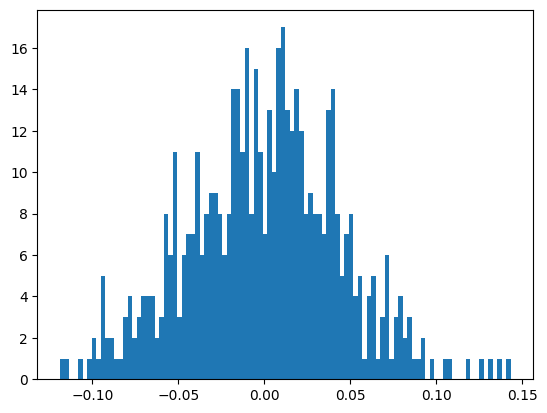

In [20]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
max_activation = dictionary_activations[:, best_feature].max()
weights = smaller_dict[best_feature]
plt.hist(weights, bins=100)
plt.show()

In [21]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

(torch.return_types.topk(
 values=tensor([0.4587, 0.4407, 0.4183, 0.4015, 0.3814, 0.3496, 0.3330, 0.3156, 0.2968,
         0.2948, 0.2846, 0.2781, 0.2736, 0.2714, 0.2680, 0.2593, 0.2587, 0.2563,
         0.2554, 0.2505]),
 indices=tensor([478, 436,  98, 321,  87, 458, 230, 464, 129,  31, 137, 377, 263, 401,
         291,  92, 132,  56, 109, 246])),
 tensor([-0.3796, -0.3700, -0.3456, -0.3286, -0.3197, -0.3164, -0.3107, -0.3015,
         -0.3011, -0.3000, -0.2976, -0.2964, -0.2894, -0.2886, -0.2828, -0.2822,
         -0.2763, -0.2675, -0.2606, -0.2588]),
 tensor(39))

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [19]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token]
Top-20 increasing: ['に', 'を', 'でも', 'が', 'には', 'も', 'ことが', 'は', 'で', 'の', 'では', 'って', 'して', 'から', 'と', 'ると', 'て', 'という', 'によ', 'ی']
Top-20 increasing: ['3.60', '3.33', '3.11', '3.08', '3.07', '3.00', '2.96', '2.85', '2.72', '2.69', '2.54', '2.43', '2.40', '2.33', '2.32', '2.32', '2.18', '2.14', '2.00', '1.97']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 49992
に[token]
Top-20 increasing: ['には', 'を', 'に', 'でも', 'ことが', 'が', 'という', 'も', 'は', 'では', 'で', 'って', 'の', 'ると', 'から', 'と', 'にな', 'して', 'その', 'として']
Top-20 increasing: ['3.71', '3.67', '3.60', '3.30', '3.30', '3.24', '3.23', '3.22', '3.11', '3.04', '3.03', '2.99', '2.90', '2.83', '2.78', '2.70', '2.65', '2.61', '2.48', '2.44']
Top

In [21]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

[token]
Top-20 increasing: ['に', 'を', 'でも', 'が', 'には', 'も', 'ことが', 'は', 'で', 'の', 'では', 'って', 'して', 'から', 'と', 'ると', 'て', 'という', 'によ', 'ی']
Top-20 increasing: ['3.60', '3.33', '3.11', '3.08', '3.07', '3.00', '2.96', '2.85', '2.72', '2.69', '2.54', '2.43', '2.40', '2.33', '2.32', '2.32', '2.18', '2.14', '2.00', '1.97']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 49992
[token]に
Top-20 increasing: ['Chief', '\\!\\!\\!\\!', 'DLT', ' 1866', '0101', '1101', 'ht', 'DT', 'FIX', 'varn', 'AGT', ' 1945', 'ähler', 'GTT', ' 1865', 'DH', 'ITC', 'ogon', 'andem', ' Hodge']
Top-20 increasing: ['4.61', '4.51', '4.51', '4.51', '4.50', '4.50', '4.50', '4.49', '4.47', '4.47', '4.46', '4.46', '4.46', '4.45', '

In [24]:
prepend_all_tokens_and_get_feature_activation(model, " ", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token] for all $
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304


'<|endoftext|> for all $'